## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.


##### Questions:
1)	Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue
2)	Build a model to select the best customers to target that maximizes the Incremental Response Rate and Net Incremental Revenue. 
##### Deliverables
3)	Score the ‘Test.csv’ using the model and select the best customers and share the customer ID’s as  csv file 
4)	Explain briefly the approach used in a separate document and also share the code that can be executed to reproduce results.


# Notebook 3: Modeling of promotion strategy
### Target Marketing: Identify the best customers we should send promotions to. <br>

This notebook learns the patterns of those individuals who purchased the product after receiving a promotion, using only the treatment dataset. <br>

There are no strong linear relations between independent and dependent features; therefore, a tree-based algorithm was selected.
XGBOOST was selected for this solution due to its extendability to custom metrics and objective functions, and extensive hyperparameters to control overfitting. <br>

XGBOOST algorithm was extended to use a custom metric 'IRR' to maximize individuals who purchased the product after receiving a promotion. My thinking is, the more people who purchase the product, the more revenue we will make. A custom objective function was used to calculate weighted class loss to handle imbalance between classes.


## Table of contents

- [Data gathering](#data)
- [Feature Engineering](#feature)
- [Preprocessing](#preprocessing)
- [Setting a baseline](#baseline)
- [Hyperparameter tuning](#hyper)
- [Evaluation]((#eval)

In [1]:
import logging
import warnings
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import optuna.logging
import optuna.visualization as vis
import pandas as pd
import xgboost as xgb
from imblearn.combine import SMOTEENN
from optuna.samplers import TPESampler
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src import Seafoam, config, feature_engineering_training, feature_engineering_testing, WeightedImbalanceLoss
from test_results import test_results

%matplotlib inline

# font standardization
seafoam = Seafoam()

#suppress warnings
warnings.filterwarnings('ignore')

In [2]:
THRESHOLD = 0.55

In [3]:
def irr_score(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    """ 
    Define a custom metric to calculate irr score 
    
    Since a custom objective is also supplied, the predt is untransformed leaf weight which needs transformation
    Custom metric receives raw input only when custom objective is also being used
    
    The calculation is based on this concept
    irr = tp / (tp + fp) - fn / (fn + tn)
    
    Args:
        predt (np.ndarray): untransformed leaf weight
        dtrain (xgb.DMatrix): training data
    Returns:
        irr (float): irr score
    """
    
    # Get actual label values
    y_true = dtrain.get_label()
    # print('irr pred unconverted {}'.format(predt[:10]))
    # Convert predictions to probabilities using sigmoid
    predt = 1.0 / (1.0 + np.exp(-predt))
    # 
    # round values to 0 or 1
    # print('irr pred converted sigmoid {}'.format(predt[:10]))
    
    # convert probabilities to outputs 1 or 0, using a defined threshold
    predt = np.where(predt > THRESHOLD, 1, 0)
    # print('irr pred converted {}'.format(predt[:10]))
    
    tn, fp, fn, tp = confusion_matrix(y_true, predt).ravel()
    
    if (tp + fp) != 0:
        ratio_promotion = tp / (tp + fp)
    else:
        ratio_promotion = 0
        
    if (fn + tn) != 0:
        ratio_nopromotion = fn / (fn + tn)
    else:
        ratio_nopromotion = 0
        
    irr = ratio_promotion - ratio_nopromotion
    
    return 'irr_score', irr


def promotion_strategy(df, model):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should receive a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    df = feature_engineering_testing(df, onehot=True, drop_first=True)
    dtest = xgb.DMatrix(df, enable_categorical=False)
    preds_raw = model.predict(dtest, output_margin=True)
    preds = 1 / (1 + np.exp(-preds_raw))
    promotion = np.where(preds > THRESHOLD, "Yes", "No")
    
    return promotion

In [4]:
# activate logging for optuna hyper parameter tuning
logger = logging.getLogger(__name__)
logging.basicConfig(filename=config.path_log_ml,
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    filemode='w',
                    level=logging.INFO,
                    datefmt='%Y-%m-%d %H:%M:%S')

In [5]:
RANDOM_STATE=88

## Data Gathering <a name="data"></a>

In [6]:
# load in the training data
train_data = pd.read_csv(config.path_train_data)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [7]:
train_data.shape

(84534, 10)

## Feature Engineering <a name="feature"></a>
Prepare data for modelling

In [8]:
df_ml = feature_engineering_training(train_data.copy(deep=True), onehot=True, drop_first=True)
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42364 entries, 8 to 126181
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   purchase  42364 non-null  int64  
 1   V3        42364 non-null  float64
 2   V4_2      42364 non-null  int8   
 3   V5_2      42364 non-null  int8   
 4   V5_3      42364 non-null  int8   
 5   V5_4      42364 non-null  int8   
dtypes: float64(1), int64(1), int8(4)
memory usage: 1.1 MB


## Preprocessing <a name="preprocessing"></a>

In [9]:
logger.info('Logging started...')

In [10]:
X = df_ml.drop(['purchase'], axis=1, errors='ignore')
y = df_ml['purchase'].copy(deep=True)
X.shape, y.shape

((42364, 5), (42364,))

In [11]:
X.head()

,V3,V4_2,V5_2,V5_3,V5_4
ID,,,,,
8,-0.385883,0,0,0,0
15,0.393317,1,0,1,0
17,-1.511395,1,0,0,0
20,0.133583,1,0,1,0
22,-0.905350,1,1,0,0


In [12]:
# split dataset into train and test datasets
X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.20, 
    random_state=RANDOM_STATE
)

# resample the minority class
# resample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_STATE)
# smote = SMOTE(k_neighbors=5, random_state=RANDOM_STATE, sampling_strategy='minority')
smenn = SMOTEENN( random_state=RANDOM_STATE)
X_resampled, y_resampled = smenn.fit_resample(X_train, y_train)

# Show the results of the split
print("Training dataset has {} samples.".format(X_train.shape[0]))
print("Validation dataset has {} samples.".format(X_validation.shape[0]))
# print("Test dataset has {} samples.".format(X_test.shape[0]))
print("Resampled Training dataset has {} samples.".format(X_resampled.shape[0]))
print("Resampled Training label dataset has {} samples.".format(y_resampled.shape[0]))

Training dataset has 33891 samples.
Validation dataset has 8473 samples.
Resampled Training dataset has 42459 samples.
Resampled Training label dataset has 42459 samples.


In [13]:

print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({0: 33314, 1: 577})
Resampled dataset shape Counter({0: 32217, 1: 10242})


In [14]:
X_train.head()

,V3,V4_2,V5_2,V5_3,V5_4
ID,,,,,
27495,-0.645617,1,0,1,0
35002,1.345672,1,0,1,0
85085,1.345672,1,0,1,0
8181,-0.991928,1,0,1,0
22557,0.393317,0,0,0,1


## Setting a baseline <a name="baseline"></a>

In [15]:
# build training and validation dmatrixes, using the unsampled data instead, use weighted loss to control imbalance
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=False)
# dtrain = xgb.DMatrix(X_resampled, label=y_resampled, enable_categorical=True)
dval = xgb.DMatrix(X_validation, label=y_validation, enable_categorical=False)
evals = [(dval, 'test')]

In [ ]:
# Set feature weights, with V3, V4 and V5 features with higher weights
# fw = np.ones(X.shape[1])
# 
# # V3
# fw[0] = 20
# 
# # V4_2, V5
# fw[6:11] = 10
# 
# dtrain.set_info(feature_weights=fw)
# dval.set_info(feature_weights=fw)
# 
# # fw
# print(fw)


In [ ]:
# fw =[1, 1, 10, 10, 10, 1, 1]
# dtrain.set_info(feature_weights=fw)
# dval.set_info(feature_weights=fw)

In [16]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
scale_pos_weight

57.73656845753899

In [17]:
# when coding a custom objective function, do not specify a default objective as a base
# output of model is raw prediction weights at leaf nodes, which needs to be transformed to probability with sigmoid
initial_params = {
    'random_state': RANDOM_STATE,
    'scale_pos_weight': scale_pos_weight,
    'max_delta_step': 1,
    'booster': 'gbtree',
    'max_depth': 2,
    'grow_policy': 'lossguide',
    "disable_default_eval_metric": True, 
    'tree_method': 'hist',
}

In [18]:
weighted_loss_obj = WeightedImbalanceLoss(imbalance_alpha=60)

In [19]:
# Use custom objective and metric, use validation dataset evaluate the results
results = {}
base_model = xgb.train(params=initial_params,
                       dtrain=dtrain,
                       num_boost_round=10,
                       evals=evals,
                       obj=weighted_loss_obj.weighted_binary_cross_entropy,
                       custom_metric = irr_score,
                       verbose_eval=5,
                       evals_result=results,
                       early_stopping_rounds=5,
                       maximize=True,
                       )

# get prediction
y_pred_raw = base_model.predict(dval, output_margin=True)
# convert leaf raw weights to probabilities
preds = 1 / (1 + np.exp(-y_pred_raw))
print('AUC: {}'.format(roc_auc_score(y_validation, preds)))
# convert to labels 1 or 0 based on threshold
pred_labels = (preds > THRESHOLD).astype(int)
accuracy = accuracy_score(y_validation, pred_labels)
print('Accuracy: {}'.format(accuracy))

[0]	test-irr_score:0.01393
[5]	test-irr_score:0.01850
[6]	test-irr_score:0.01850
AUC: 0.6460221815343978
Accuracy: 0.5786616310633778


In [20]:
print(classification_report(y_validation, pred_labels, zero_division=0, output_dict=False))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      8329
           1       0.03      0.69      0.05       144

    accuracy                           0.58      8473
   macro avg       0.51      0.64      0.39      8473
weighted avg       0.97      0.58      0.72      8473



In [21]:
# print confusion metrix
print('\nConfusion matrix : \n{}'.format(confusion_matrix(y_validation, pred_labels)))


Confusion matrix : 
[[4803 3526]
 [  44  100]]


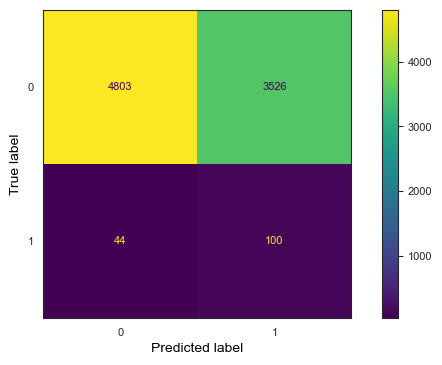

In [22]:

cm = confusion_matrix(y_validation, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

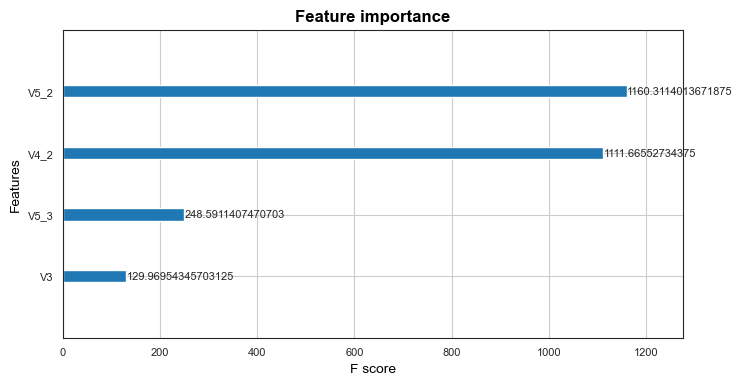

In [23]:
xgb.plot_importance(base_model, importance_type='gain')
plt.show()


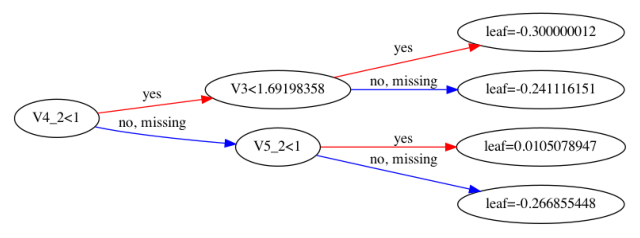

In [24]:
# Plot the first tree
xgb.plot_tree(base_model, num_trees=0, rankdir='LR')
plt.show()

## Hyperparameter tuning <a name="hyper"></a>

In [25]:
storage_name = config.path_database_optuna
print('Location of optuna database: {}'.format(storage_name))


Location of optuna database: sqlite:////Users/juanitasmith/Documents/Udacity/projects/ab_testing_starbucks/data/clean/starbucks.db


In [26]:
# print existing studies
study_summaries = optuna.study.get_all_study_summaries(storage=storage_name)
for x in study_summaries:
    print(x.study_name)

xgboost-starbucks-irr_with_v2-scaled_adjusted_parms25
xgboost-starbucks-irr-1
xgboost-starbucks-irr-2
xgboost-starbucks-irr-3


In [27]:
# optuna.delete_study(study_name="xgboost-starbucks-irr_with_v2-scaled_adjusted_parms1", storage=storage_name)

In [28]:
# Unique identifier of the study
study_name = "xgboost-starbucks-irr-3"

# Propagate logs to the root logger
optuna.logging.enable_propagation() 

# Stop showing logs in sys.stderr
optuna.logging.disable_default_handler() 

In [29]:
def objective(trial, dtrain, dvalid, scoring, initial_params):
    """ Grid search using Bayes Optimization with OPTUNA

    Args:
        trial
        dtrain: (xgb.DMatrix) - training dataset
        dvalid: (xgb.DMatrix) - validation dataset
        scoring: (str) - scoring metric to use during parameter search
        initial_params: (dict) - initial parameters as per baseline model

    Return:
        objective_score: score of a trial
    """

    params = {
        "disable_default_eval_metric": True,
        # 'tree_method': trial.suggest_categorical('tree_method', ['exact', 'hist']),
        'max_delta_step': trial.suggest_float('max_delta_step', low=10, high=100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', low=0.5, high=1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', low=40, high=100),
        'min_data_in_leaf': trial.suggest_float('min_data_in_leaf', low=40, high=100),
        "lambda": trial.suggest_float("lambda", low=3, high=100), # reg_lambda L2 reg
        "alpha": trial.suggest_float('alpha', low=3, high=100), # same as reg_alpha L1 reg
        "max_depth": trial.suggest_int("max_depth", 1, 4),
        "eta": trial.suggest_float("eta", 0.001, 0.2), # same as learning rate
        "gamma": trial.suggest_float("gamma", 0, 20), # minimum split loss
        "num_boost_rounds": trial.suggest_int('num_boost_rounds', low=10, high=100, step=5),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
    
    initial_params.update(params)
        
    # evaluate using the test datasets but avoid doing unnecessary trials
    evals=[(dvalid, "validation")]
    test_eval= 'validation-{}'.format(scoring)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, test_eval)
    
    results = {}
    xgb.train(
        params=initial_params,
        dtrain=dtrain,
        evals=evals,
        obj=weighted_loss_obj.weighted_binary_cross_entropy,
        custom_metric = irr_score,
        verbose_eval=False,
        early_stopping_rounds=5,
        callbacks=[pruning_callback],
        maximize=True,
        evals_result=results,
    )
    
    # Extract the best score
    score = results['validation']['irr_score'][-1]
    
    return score

In [30]:
study = optuna.create_study(sampler=TPESampler(), 
                            direction="maximize", 
                            study_name=study_name,
                            storage=storage_name,
                            load_if_exists=True,
                            )


study.optimize(lambda trial: objective(trial, 
                                       scoring='irr_score',
                                       initial_params=initial_params.copy(),
                                       dtrain=dtrain,
                                       dvalid=dval), 
               n_trials=200, 
               gc_after_trial=True) 
                        

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

In [ ]:
best_params = study.best_params
best_params

In [ ]:
updated_params = initial_params.copy()
updated_params.update(best_params)
updated_params

In [ ]:
# evaluate using the test datasets but avoid doing unnessary trials
evals=[(dval, "validation")]
test_eval= 'validation-{}'.format('irr_score')
pruning_callback = optuna.integration.XGBoostPruningCallback(trial, test_eval)

results = {}
tuned_model = xgb.train(params=updated_params,
            dtrain=dtrain,
            num_boost_round=60,
            evals=evals,
            obj=weighted_loss_obj.weighted_binary_cross_entropy,
            custom_metric = irr_score,
            verbose_eval=5,
            # early_stopping_rounds=5,
            callbacks=[pruning_callback],
            maximize=True,
            evals_result=results,
            )

In [ ]:
# get prediction
y_pred_raw = tuned_model.predict(dval, output_margin=True)
preds = 1 / (1 + np.exp(-y_pred_raw))
print('AUC: {}'.format(roc_auc_score(y_validation, preds)))
pred_labels = (preds > THRESHOLD).astype(int)
accuracy = accuracy_score(y_validation, pred_labels)
print('Accuracy: {}'.format(accuracy))

In [ ]:
print(classification_report(y_validation, pred_labels, zero_division=0, output_dict=False))

In [ ]:
# print confusion metrix
print('\nConfusion matrix : \n{}'.format(confusion_matrix(y_validation, pred_labels)))

In [ ]:

cm = confusion_matrix(y_validation, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

In [ ]:
xgb.plot_importance(tuned_model, importance_type='gain')
plt.show()

In [ ]:
# Plot the first tree
xgb.plot_tree(tuned_model, num_trees=0)

## Evaluation <a name="eval"></a>

This will test your results, and provide you back some information on how well your promotion_strategy will work in practice

In [ ]:
# base model evaluation
test_results(promotion_strategy, base_model)

In [ ]:
# tuned model evaluation - did we improve the results?
test_results(promotion_strategy, tuned_model)

## References <a name="reference"></a>

[XGBOOST handling imbalance with focal loss](https://github.com/handongfeng/Xgboost-With-Imbalance-And-Focal-Loss/blob/master/Xgboost_sklearn.py)

[XGBOOST understanding algorithm](https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/notebooks/Machine-Learning-with-XGBoost-solution.ipynb)
    
[Dynamic bin size of histograms](https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde)